## Lab 3 Final Part 2: Gaussian Mixture Model and the EM algorithm

In prior classes and Part 1 of this lab, we noted how the Hubble Constant data in recent years displays a tighter distribution than it has for most of the 20th century (with some outliers), yet in detail the data still show an apparent spread and does not appear to be unimodal.

To verify this, one approach is to test whether the set of measurements (or a population) deviates from a simple distribution (e.g. normal).  An example of such a test includes the Kolmogorov-Smirnov test. 

An alternative is to build a model that better describes the data.  Given that the recent H0 data show at least two prominent peaks, we can try to fit the distribution with a Gaussian mixture model.  Here assume that the H0 data can be described by a mixture of normal distributions, each parametrized by their mean, width and amplitude.  To perform this fit, we use an iterative method called **Expectation-Maximization (EM)**.  Unlike MCMC, which is used to sample the full posterior likelihood distribution, EM aims to converge iteratively on the best fit, highest likelihood model.

As described in detail in Chap. 12 of Bayesian Data Analysis (Gelman et al), EM is particularly useful in model fitting where there is missing data or added parameters in the model.  In our case, the missing data are parameters that tell us to which Gaussian component (or cluster) a particular data point belongs. For N data points and K different components to the model, we can imagine generating an NxK matrix that gives the likelihood (or weights) that the Nth data point belongs to Kth cluster. (This matrix is the missing data, and the EM algorithm iteratively refines the expected value of this matrix of weights, in the 'E-step'.)   Additionally in each 'M-step' a new set of model parameters is determined that maximizes the likelihood, progressingly increasing it until it converges on a solution.

The implementation we use here borrows from a version from M Pattacchiola "Implementation of a Gaussian Mixture Model" https://gist.github.com/mpatacchiola/f892afb2d178246af133851e42c8fefc.js, which itself is built on the algorithm as described in the "Mathematics for Machine Learning" (Diesenroth, Faisal and Ong)

### Basic EM steps

Start with an estimate of model parameters (e.g. parameters for each of the Gaussian distributions used in the fit)

* E-step: Estimate the expected value of the 'added parameters', in our case the matrix of mixture weights for each data point.  In the implementation we use, this matrix is called the "responsibility" matrix.
* M-step: Find a new set of parameters that maximize (or more generally increase) the likelihood of the fit

Iterate through EM steps until convergence

### Gaussian mixture model

Experiment below with a Gaussian mixture model with 1, 2, 3 parameters.  We will compare the models both by visually inspecting the fit and 
also using criteria for model selection, AIC and BIC.

Note however, that Gaussian mixture model fitting can be very sensitive to outliers that might throw off the fit, and the
algorithm can be sensitive to the choice of initial parameter!   


#### Comment on fitting a Gaussian Mixture Model to our H0 data:  

You might note that we have prior knowledge that could allow us to determine the weights in advance (we ***don't*** have missing parameters) since we know that some of the H0 data were obtained from CMB data, and others from low-z measurements. etc.  This may be true, but the approach we adopt here is agnostic to that prior knowledge regarding the method used to obtain the data.

### Step 1: Read in Hubble Constant Data and Trim Data (remove outliers, select more recent)

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.stats import norm
import scipy.stats as stats

['2' 'A' 'AC' 'AK' 'AS' 'AT' 'AV' 'B' 'BK' 'BS' 'C' 'CC' 'CI' 'CK' 'CM'
 'CT' 'D' 'DK' 'F' 'FK' 'FS' 'G' 'GK' 'GS' 'GV' 'H' 'HK' 'I' 'IND' 'L'
 'LC' 'LCDM' 'LI' 'M' 'N' 'NS' 'NV' 'O' 'OC' 'OK' 'OS' 'OV' 'P' 'PK' 'R'
 'S' 'SC' 'SI' 'SK' 'SS' 'SV' 'T' 'TK' 'TS' 'Z' 'ZC' 'ZI' 'rK']


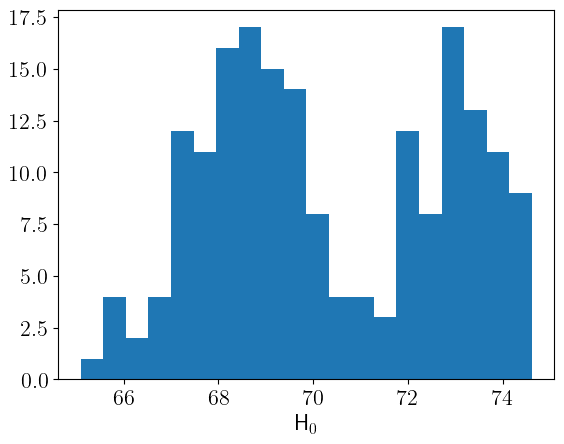

In [83]:
# Read in the data from a CSV compilation file

# Table of Hubble Constant measurements, over past ~100 years
from astropy.table import Table

# Read the CSV file
table = Table.read("./H0_Data.csv", format="ascii.csv")


year = np.array(table["Year"], dtype="float64")
dither = np.random.uniform(size=len(year))
# Add a small dither offset to year to avoid integer pile-up
year_dith = year + dither


H0 = np.array(table["H0"], dtype="float64")
eH0 = np.array(table["eH0"], dtype="float64")
no_errors = np.where(eH0 < 0.1)[0]
# Replace some with very small error bars with a larger value so as not to interfere
eH0[no_errors] = 5
obsType = np.array(table["ObsType"])
print(np.unique(obsType))

# Trim outliers and store most recent Hubble Constant Data in data array
# Experiment with these (should be fairly narrow, centered around 70 (better +/-10 or +/-5, and may want more recent, 2010)
mincut = 65
maxcut = 75
min_year = 2010

p = np.where((H0 > mincut) & (H0 < maxcut) & (year_dith > min_year))[0]
H0cut = H0[p]
eH0cut = eH0[p]
obsTypecut = obsType[p]
year_dith_cut = year_dith[p]

data = H0[p]

hist, bins, _ = plt.hist(data, bins=20)
plt.xlabel("H$_0$")
plt.show()

In [84]:
#### Gaussian Mixture Model Functions


# Plot the data distributions
def plot_distributions(
    data,
    data_sampled,
    mu,
    sigma,
    K,
    color="green",
    color_sampled="red",
    name="plot.png",
):
    matplotlib.rcParams["text.usetex"] = True
    plt.rcParams.update({"font.size": 16})
    data_sampled = np.clip(data_sampled, np.min(data), np.max(data))
    plt.hist(data, bins=30, color=color, alpha=0.45, density=True)
    plt.hist(
        data_sampled,
        bins=15,
        range=(np.min(data), np.max(data)),
        color=color_sampled,
        alpha=0.45,
        density=True,
    )
    for k in range(K):
        curve = np.linspace(mu[k] - 10 * sigma[k], mu[k] + 10 * sigma[k], 100)
        color = np.random.rand(3)
        plt.plot(
            curve,
            stats.norm.pdf(curve, mu[k], sigma[k]),
            color=color,
            linestyle="--",
            linewidth=3,
            label=r"$\mu_{} = {:.2f}, \sigma_{} = {:.2f}$".format(
                k, mu[k], k, sigma[k]
            ),
        )
    plt.ylabel(r"$p(x)$")
    plt.xlabel(r"$x$")
    plt.tight_layout()
    #    plt.xlim(20, 120)
    plt.xlim(50, 90)
    plt.savefig(name, dpi=200)
    plt.legend()
    plt.show()


# Show the evolution of the likelihood
def plot_likelihood(nll_list):
    matplotlib.rcParams["text.usetex"] = True
    plt.rcParams.update({"font.size": 16})
    plt.plot(
        np.arange(len(nll_list)), nll_list, color="black", linestyle="--", linewidth=3
    )
    plt.ylabel(r"(negative) log-likelihood")
    plt.xlabel(r"iteration")
    plt.tight_layout()
    plt.xlim(0, len(nll_list))
    plt.savefig("nll_k=2.png", dpi=200)
    plt.show()


# Draw samples from the final mixture model
def sampler(pi, mu, sigma, N):
    data = list()
    for n in range(N):
        k = np.random.choice(len(pi), p=pi)
        sample = np.random.normal(loc=mu[k], scale=sigma[k])
        data.append(sample)
    return data

Iteration: 0; NLL: 430.7612607397487
Mean [69.63234763 71.44878778]
Std [2.5008967  1.93879165]
Weights [0.61883959 0.38116041]

Iteration: 1; NLL: 428.94577228555784
Mean [69.58089145 71.58958328]
Std [2.3464923  2.12590257]
Weights [0.62970365 0.37029635]

Iteration: 2; NLL: 428.53273739651684
Mean [69.5279968  71.69502469]
Std [2.2763725  2.15856954]
Weights [0.63235088 0.36764912]

Iteration: 3; NLL: 428.13017731752615
Mean [69.4666968  71.80134377]
Std [2.23059748 2.13014004]
Weights [0.63249009 0.36750991]

Iteration: 4; NLL: 427.49245882711807
Mean [69.39267351 71.92274289]
Std [2.18455115 2.06959933]
Weights [0.63161912 0.36838088]

Iteration: 5; NLL: 426.3789698784927
Mean [69.3017829  72.06772319]
Std [2.1261494  1.97999545]
Weights [0.63017285 0.36982715]

Iteration: 6; NLL: 424.30186765878994
Mean [69.18933666 72.24294109]
Std [2.0450826  1.85275851]
Weights [0.62818824 0.37181176]

Iteration: 7; NLL: 420.24629229282766
Mean [69.05156588 72.45102709]
Std [1.92866363 1.67263

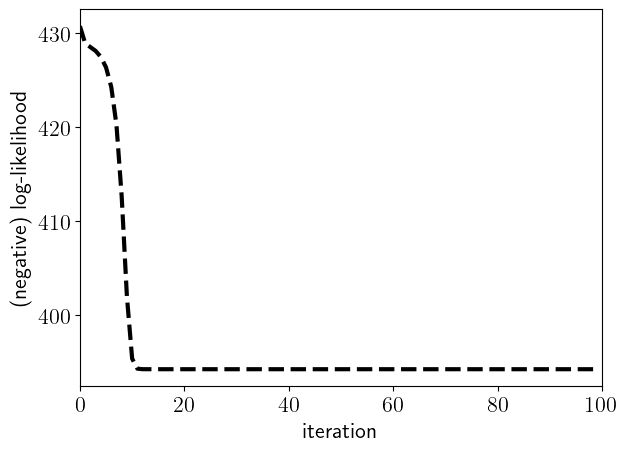

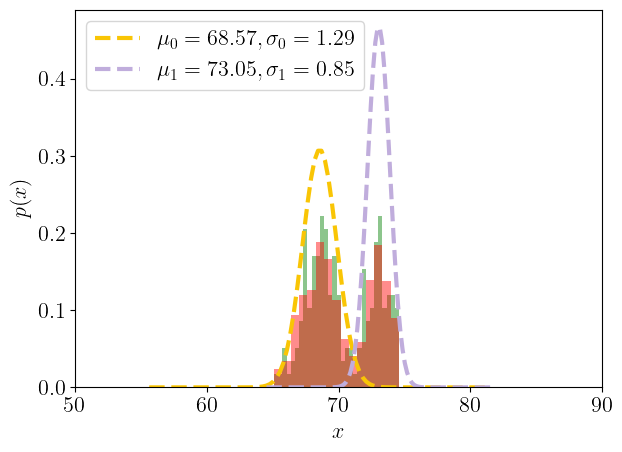

N:  185 K: 2 NLL:394.28658849431747
AIC:800.5731769886349
BIC:409.94765596955244


In [85]:
# Basic parameters of the mixture model
N = data.shape[0]  # Number of data points
K = 2  # set number of components components GMM    *** CHANGE THIS TO CHANGE NUMBER OF GAUSSIANS
tot_iterations = 100  # stopping criteria    (Probably no need to edit this)

# Step-1 (Init) - Draw parameters for each gaussian

mu = np.random.uniform(low=mincut, high=maxcut, size=K)  # mean
sigma = np.random.uniform(low=0.5, high=2.0, size=K)  # width
pi = np.ones(K) * (1.0 / K)  # mixing coefficients (amplitudes)

# Matrices of individual weights 'responsibilities' and negative log-likelihoods
r = np.zeros(
    [K, N]
)  # responsibilities, with Mixture model # along first axis, Measurements on 2nd axis
nll_list = list()  # store the neg log-likelihood


for iteration in range(tot_iterations):
    # Step-2 (E-Step)     # Here the expectation for 'responsibility' for each model is simply

    # drawn from a Gaussian pdf, with current mean, sigma, and amplitude
    for k in range(K):
        r[k, :] = pi[k] * norm.pdf(x=data, loc=mu[k], scale=sigma[k])

    # [K,N] -> [N]      # be sure to properly normalize across K
    r = r / np.sum(r, axis=0)

    # Step-3 (M-Step)
    N_k = np.sum(r, axis=1)  # [K,N] -> [K]
    for k in range(K):  # Maximum likelihood extimates
        # update means
        mu[k] = np.sum(r[k, :] * data) / N_k[k]  # Weighted mean for each Gaussian
        # update variances
        numerator = r[k] * (data - mu[k]) ** 2
        sigma[k] = np.sqrt(
            np.sum(numerator) / N_k[k]
        )  # Weighted width for each Gaussian
        # See questions - you might insert code for fixing params here in order to model OUTLIERS
    # update weights
    pi = N_k / N  # New updated amplitude

    likelihood = 0.0
    for k in range(K):
        likelihood += pi[k] * norm.pdf(
            x=data, loc=mu[k], scale=sigma[k]
        )  # calculate new likelihood
    nll_list.append(-np.sum(np.log(likelihood)))
    # Check for invalid negative log-likelihood (NLL)
    # The NLL is invalid if NLL_t-1 < NLL_t
    # Note that this can happen for round-off errors.  DS - added int to avoid chronic round-off errors
    if len(nll_list) >= 2:
        if int(nll_list[-2] * 1e7) < int(nll_list[-1] * 1e7):
            raise Exception("[ERROR] invalid NLL: " + str(nll_list[-2:]))

    print("Iteration: " + str(iteration) + "; NLL: " + str(nll_list[-1]))
    print("Mean " + str(mu) + "\nStd " + str(sigma) + "\nWeights " + str(pi) + "\n")

    # Step-4 (Check)
    if iteration == tot_iterations - 1:
        break  # check iteration

# Make plots
plot_likelihood(nll_list)

# SAMPLE from the GMM, 1000 data points, for comparison with the measured data
data_gmm = sampler(pi, mu, sigma, N=1000)
plot_distributions(
    data,
    data_gmm,
    mu,
    sigma,
    2,
    color="green",
    color_sampled="red",
    name="plot_sampler.png",
)
# Calculate AIC and BIC assuming k gaussians with 3 parameters each
# number of free parameters for k gaussians with 3 free parameters p=3k−1,
BIC = nll_list[-1] + (3 * K) / 2 * np.log(N)
AIC = 2 * (3 * K) + 2 * nll_list[-1]
# Remember NLL is negative log-likelihood!
print("N:  " + str(N) + " K: " + str(K) + " NLL:" + str(nll_list[-1]))
print("AIC:" + str(AIC))
print("BIC:" + str(BIC))

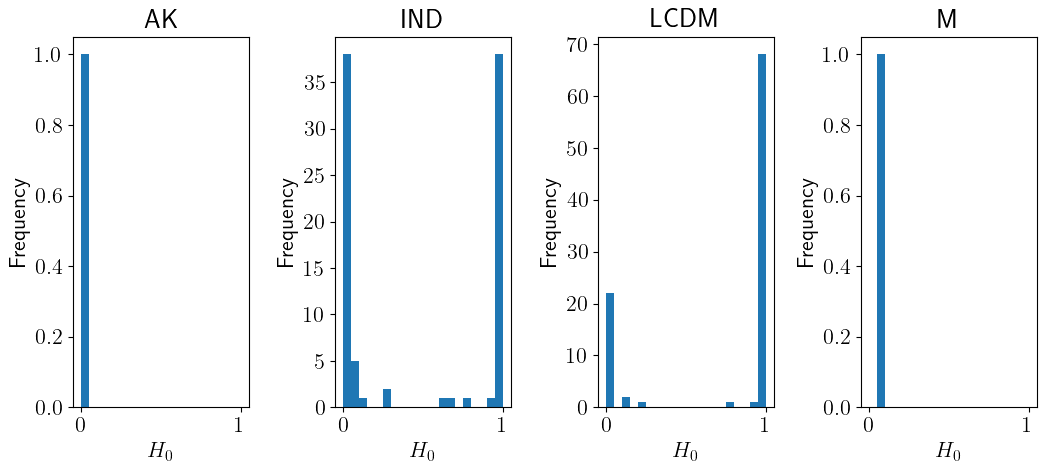

In [86]:
# Example histograms to show how obsType classifications compare to the GMM classification
obsTypes = np.unique(obsTypecut)
num_obsTypes = len(obsTypes)

fig, axes = plt.subplots(nrows=(num_obsTypes // 5) + 1, ncols=6, figsize=(16, 5))
axes = axes.flatten()

# for all the different types of observations, plot the H0 values
# where r is  Matrices of individual weights 'responsibilities' and negative log-likelihoods
# here, r[0] is the GMM classification
for i, otype in enumerate(obsTypes):
    p = np.where(otype == obsTypecut)
    axes[i].hist(r[0, p[0]], bins=20, range=(0, 1))
    axes[i].set_xlabel(r"$H_0$")
    axes[i].set_title(str(otype))
    axes[i].set_ylabel("Frequency")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## run through and vary parameters for k=1 and k=3

## Questions on the Gaussian Mixture Model

* First, with k=2, experiment with selecting a set of outlier cuts (min, max) and starting year to get a clean double-peaked data set that should give you a sensible fit.

> see above for the clean double-peaked data


* Once you have a good set of fits with k=2, perform runs with with k = 1, 2 and 3 Gaussian functions in your 'mixture model'.


Iteration: 0; NLL: 429.48994893349845
Mean [70.3247027]
Std [2.46607732]
Weights [1.]

Iteration: 1; NLL: 429.48994893349845
Mean [70.3247027]
Std [2.46607732]
Weights [1.]

Iteration: 2; NLL: 429.48994893349845
Mean [70.3247027]
Std [2.46607732]
Weights [1.]

Iteration: 3; NLL: 429.48994893349845
Mean [70.3247027]
Std [2.46607732]
Weights [1.]

Iteration: 4; NLL: 429.48994893349845
Mean [70.3247027]
Std [2.46607732]
Weights [1.]

Iteration: 5; NLL: 429.48994893349845
Mean [70.3247027]
Std [2.46607732]
Weights [1.]

Iteration: 6; NLL: 429.48994893349845
Mean [70.3247027]
Std [2.46607732]
Weights [1.]

Iteration: 7; NLL: 429.48994893349845
Mean [70.3247027]
Std [2.46607732]
Weights [1.]

Iteration: 8; NLL: 429.48994893349845
Mean [70.3247027]
Std [2.46607732]
Weights [1.]

Iteration: 9; NLL: 429.48994893349845
Mean [70.3247027]
Std [2.46607732]
Weights [1.]

Iteration: 10; NLL: 429.48994893349845
Mean [70.3247027]
Std [2.46607732]
Weights [1.]

Iteration: 11; NLL: 429.48994893349845
Mea

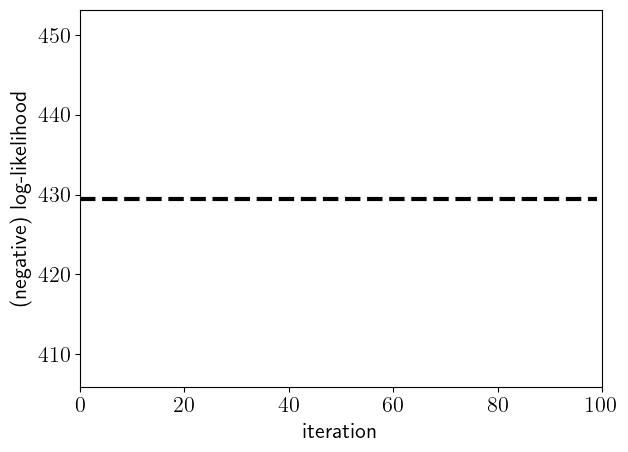

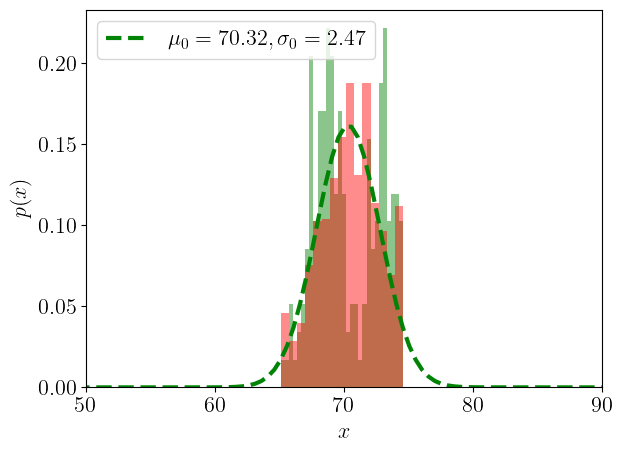

N:  185 K: 1 NLL:429.48994893349845
AIC:864.9798978669969
BIC:437.32048267111594


In [87]:
# Basic parameters of the mixture model

N = data.shape[0]  # Number of data points
K = 1  # set number of components components GMM    *** CHANGE THIS TO CHANGE NUMBER OF GAUSSIANS
tot_iterations = 100  # stopping criteria    (Probably no need to edit this)

# Step-1 (Init) - Draw parameters for each gaussian

mu = np.random.uniform(low=mincut, high=maxcut, size=K)  # mean
sigma = np.random.uniform(low=0.5, high=2.0, size=K)  # width
pi = np.ones(K) * (1.0 / K)  # mixing coefficients (amplitudes)

# Matrices of individual weights 'responsibilities' and negative log-likelihoods
r = np.zeros(
    [K, N]
)  # responsibilities, with Mixture model # along first axis, Measurements on 2nd axis
nll_list = list()  # store the neg log-likelihood


for iteration in range(tot_iterations):
    # Step-2 (E-Step)     # Here the expectation for 'responsibility' for each model is simply
    # drawn from a Gaussian pdf, with current mean, sigma, and amplitude
    for k in range(K):
        r[k, :] = pi[k] * norm.pdf(x=data, loc=mu[k], scale=sigma[k])

    # [K,N] -> [N]      # be sure to properly normalize across K
    r = r / np.sum(r, axis=0)

    # Step-3 (M-Step)
    N_k = np.sum(r, axis=1)  # [K,N] -> [K]
    for k in range(K):  # Maximum likelihood extimates
        # update means
        mu[k] = np.sum(r[k, :] * data) / N_k[k]  # Weighted mean for each Gaussian
        # update variances
        numerator = r[k] * (data - mu[k]) ** 2
        sigma[k] = np.sqrt(
            np.sum(numerator) / N_k[k]
        )  # Weighted width for each Gaussian
        # See questions - you might insert code for fixing params here in order to model OUTLIERS
    # update weights
    pi = N_k / N  # New updated amplitude

    likelihood = 0.0
    for k in range(K):
        likelihood += pi[k] * norm.pdf(
            x=data, loc=mu[k], scale=sigma[k]
        )  # calculate new likelihood
    nll_list.append(-np.sum(np.log(likelihood)))
    # Check for invalid negative log-likelihood (NLL)
    # The NLL is invalid if NLL_t-1 < NLL_t
    # Note that this can happen for round-off errors.  DS - added int to avoid chronic round-off errors
    if len(nll_list) >= 2:
        if int(nll_list[-2] * 1e7) < int(nll_list[-1] * 1e7):
            raise Exception("[ERROR] invalid NLL: " + str(nll_list[-2:]))

    print("Iteration: " + str(iteration) + "; NLL: " + str(nll_list[-1]))
    print("Mean " + str(mu) + "\nStd " + str(sigma) + "\nWeights " + str(pi) + "\n")

    # Step-4 (Check)
    if iteration == tot_iterations - 1:
        break  # check iteration

# Make plots
plot_likelihood(nll_list)

# SAMPLE from the GMM, 1000 data points, for comparison with the measured data
data_gmm = sampler(pi, mu, sigma, N=1000)
plot_distributions(
    data,
    data_gmm,
    mu,
    sigma,
    K,
    color="green",
    color_sampled="red",
    name="plot_sampler.png",
)
# Calculate AIC and BIC assuming k gaussians with 3 parameters each
# number of free parameters for k gaussians with 3 free parameters p=3k−1,
BIC = nll_list[-1] + (3 * K) / 2 * np.log(N)
AIC = 2 * (3 * K) + 2 * nll_list[-1]

# Remember NLL is negative log-likelihood!
print("N:  " + str(N) + " K: " + str(K) + " NLL:" + str(nll_list[-1]))
print("AIC:" + str(AIC))
print("BIC:" + str(BIC))

Iteration: 0; NLL: 402.75564821591735
Mean [69.29625094 67.62891894 72.91557676]
Std [1.56306599 1.14781129 1.11645904]
Weights [0.44697831 0.18406977 0.36895191]

Iteration: 1; NLL: 396.31708127182515
Mean [69.10696526 67.78411491 73.04297609]
Std [1.44478272 1.08064529 0.91809703]
Weights [0.4364153  0.19025755 0.37332715]

Iteration: 2; NLL: 394.94569547361755
Mean [69.013058   67.8548507  73.08391242]
Std [1.36837536 1.07863173 0.84339872]
Weights [0.43095376 0.19216826 0.37687798]

Iteration: 3; NLL: 394.71618136270047
Mean [68.97024637 67.88678788 73.08886392]
Std [1.33350635 1.10061307 0.82860532]
Weights [0.42858002 0.19203949 0.37938049]

Iteration: 4; NLL: 394.5979861450843
Mean [68.94417074 67.90423312 73.08438118]
Std [1.31170632 1.12683012 0.82891681]
Weights [0.42690792 0.19153697 0.38155511]

Iteration: 5; NLL: 394.50524046557865
Mean [68.92420486 67.91524864 73.07828044]
Std [1.29275664 1.1514759  0.83223   ]
Weights [0.42540384 0.19105403 0.38354213]

Iteration: 6; NLL

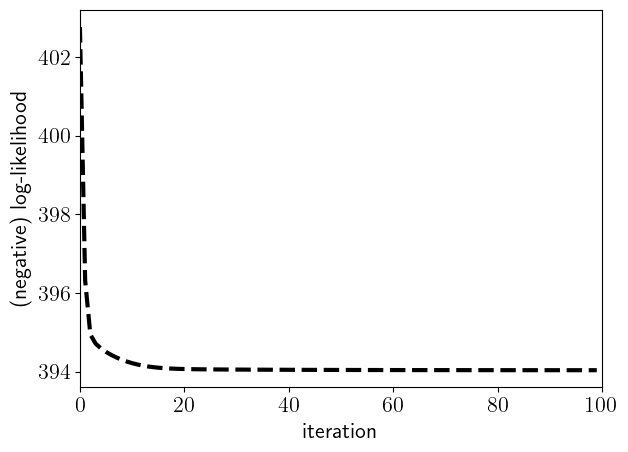

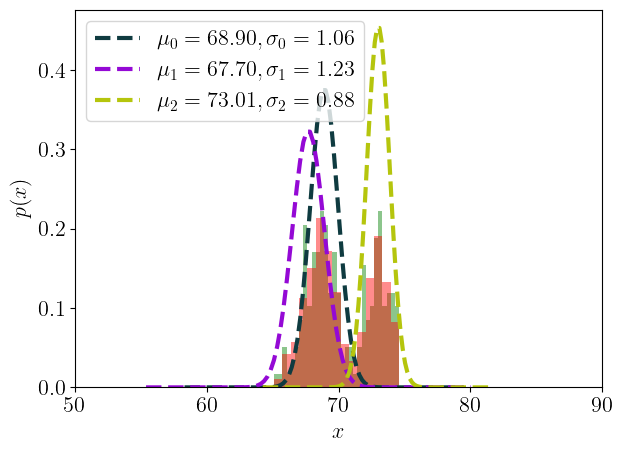

N:  185 K: 3 NLL:394.0401189147185
AIC:806.080237829437
BIC:417.53172012757096


In [88]:
# Basic parameters of the mixture model

N = data.shape[0]  # Number of data points
K = 3  # set number of components components GMM    *** CHANGE THIS TO CHANGE NUMBER OF GAUSSIANS
tot_iterations = 100  # stopping criteria    (Probably no need to edit this)

# Step-1 (Init) - Draw parameters for each gaussian

mu = np.random.uniform(low=mincut, high=maxcut, size=K)  # mean
sigma = np.random.uniform(low=0.5, high=2.0, size=K)  # width
pi = np.ones(K) * (1.0 / K)  # mixing coefficients (amplitudes)

# Matrices of individual weights 'responsibilities' and negative log-likelihoods
r = np.zeros(
    [K, N]
)  # responsibilities, with Mixture model # along first axis, Measurements on 2nd axis
nll_list = list()  # store the neg log-likelihood


for iteration in range(tot_iterations):
    # Step-2 (E-Step)     # Here the expectation for 'responsibility' for each model is simply
    # drawn from a Gaussian pdf, with current mean, sigma, and amplitude
    for k in range(K):
        r[k, :] = pi[k] * norm.pdf(x=data, loc=mu[k], scale=sigma[k])

    # [K,N] -> [N]      # be sure to properly normalize across K
    r = r / np.sum(r, axis=0)

    # Step-3 (M-Step)
    N_k = np.sum(r, axis=1)  # [K,N] -> [K]
    for k in range(K):  # Maximum likelihood extimates
        # update means
        mu[k] = np.sum(r[k, :] * data) / N_k[k]  # Weighted mean for each Gaussian
        # update variances
        numerator = r[k] * (data - mu[k]) ** 2
        sigma[k] = np.sqrt(
            np.sum(numerator) / N_k[k]
        )  # Weighted width for each Gaussian
        # See questions - you might insert code for fixing params here in order to model OUTLIERS
    # update weights
    pi = N_k / N  # New updated amplitude

    likelihood = 0.0
    for k in range(K):
        likelihood += pi[k] * norm.pdf(
            x=data, loc=mu[k], scale=sigma[k]
        )  # calculate new likelihood
    nll_list.append(-np.sum(np.log(likelihood)))
    # Check for invalid negative log-likelihood (NLL)
    # The NLL is invalid if NLL_t-1 < NLL_t
    # Note that this can happen for round-off errors.  DS - added int to avoid chronic round-off errors
    if len(nll_list) >= 2:
        if int(nll_list[-2] * 1e7) < int(nll_list[-1] * 1e7):
            raise Exception("[ERROR] invalid NLL: " + str(nll_list[-2:]))

    print("Iteration: " + str(iteration) + "; NLL: " + str(nll_list[-1]))
    print("Mean " + str(mu) + "\nStd " + str(sigma) + "\nWeights " + str(pi) + "\n")

    # Step-4 (Check)
    if iteration == tot_iterations - 1:
        break  # check iteration

# Make plots
plot_likelihood(nll_list)

# SAMPLE from the GMM, 1000 data points, for comparison with the measured data
data_gmm = sampler(pi, mu, sigma, N=1000)
plot_distributions(
    data,
    data_gmm,
    mu,
    sigma,
    K,
    color="green",
    color_sampled="red",
    name="plot_sampler.png",
)
# Calculate AIC and BIC assuming k gaussians with 3 parameters each
# number of free parameters for k gaussians with 3 free parameters p=3k−1,
BIC = nll_list[-1] + (3 * K) / 2 * np.log(N)
AIC = 2 * (3 * K) + 2 * nll_list[-1]
# Remember NLL is negative log-likelihood!
print("N:  " + str(N) + " K: " + str(K) + " NLL:" + str(nll_list[-1]))
print("AIC:" + str(AIC))
print("BIC:" + str(BIC))

* Visually, which appears to give you the best model fit?  Do the final parameters for the Gaussian(s) seem reasonable?

> The 2-gausian, bimodal distribution appears to give the best model fit. with the NLL:394, AIC:798.573176988635, BIC:407.33747805701336. This gives two gaussians with the following parameters $\mu_0 = 68.77 \pm 1.29$ and $\mu_1 = 73.05 \pm 0.85$

* For the output of the k=1, 2, 3 models, calculate the Bayesian Information Criterion (BIC) and Akaike Information Criterion as discussed in David K's lecture.  Use the log likelihood (= -NLL), number of measurements and number of parameters.  Remember that each Gaussian has 3 parameters!

> we get the following results, since there are three parameters that are free per gaussian, there are 

single gaussian
```
N:  185 K: 1 NLL:430.36383977394127
AIC:866.7276795478825
BIC:438.19437351155875
```

double gaussian
```
N:  185 K: 2 NLL:394.1659929255925
AIC:800.331985851185
BIC:409.82706040082746
```

triple gaussian
```
N:  185 K: 3 NLL:393.97280885651645
AIC:805.9456177130329
BIC:417.4644100693689
```


* Does the BIC or AIC provide results that are consistent with what you believe to be the best model?  (Might these useful statistics for model selection?)

> Yes. The lower the BIC, the better. and the double gaussian has the lowest BIC value.


* For the k=2 model, how does the result of the mixture model compare with the classifications (obsType) in the H0 catalog?  Does the GMM appear to divide up the sample by observation type?  Are there notable differences?

> The ObsType classifications are somewhat useful, recall, ObsType is the method used for measuring Hubble constant  and  'LCDM' are typically CMB-based. There is a clear two component distribution for the `IND` and `LCDM` observation types, so it does divide up the observation types into two groups within each observation type. However, the mixture model works across all the observation types, while above we show the grouping  of measurements within these observation groups. There is an exception with  AK distribution, where in H_0, just takes one values as oppsed to two or so values in IND and LCDM.



### Application to H0 outlier selection

* There are similarities with what we were doing in the previous part of the lab (following Press 1997).  For example,
we could require one of the Gaussian components to have a fixed center and width (but not amplitude) in order to represent the 'bad data'. Try this with two components, where you fix the first component with the below code. How well does this work?  Are you able to use another Gaussian to represent the problematic tail of the distribution?    

if k==0: sigma[k]=10; mu[k]=70

> I tried K=2 at first, but using the exact values above just places one of them at the rough center of the two peaks. 

<img src="outlier_k=2_default.png" width="300">


> Doing it with K=3 below better fits the problematic bump near H_0 = 66, however. I had to play around a bit with the centering and width but ended up with the following for the 2 component and 3 component gaussian mixture models.

<img src="outlier_k=2.png" width="300">

<img src="outlier_k=3.png" width="300">

```
        if k == 0:
            sigma[k] = 2
            mu[k] = 66
```
    
Insert in the code location identified above (Look for word OUTLIER)

* In terms of outliers, how might this method identify similar outliers as the previous method?  Which outliers might not show up using this method?

> One can use this method to look at outlier data, which is assumed to be well describe by a gaussian, fit it with said gaussian so as to filter it out of the subsequent fits to "good data". Like our previous method, we assume a gaussian model is good at describing the outliers, and that the outliers themselves are easily distinguishable from the rest of the data (which, by definition is true). However, it doesn't really take into account the error of the data points themsleves, just the value. 


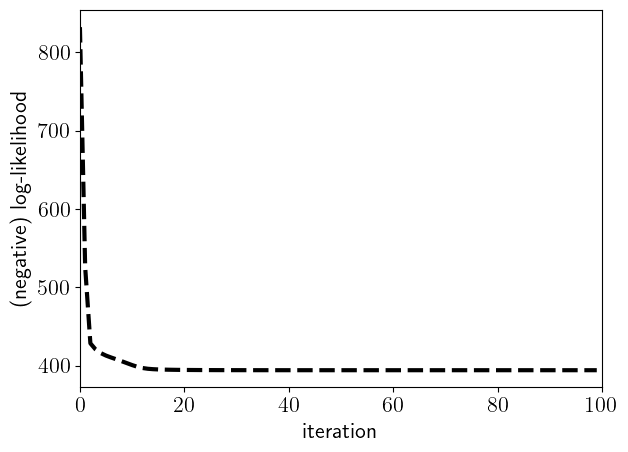

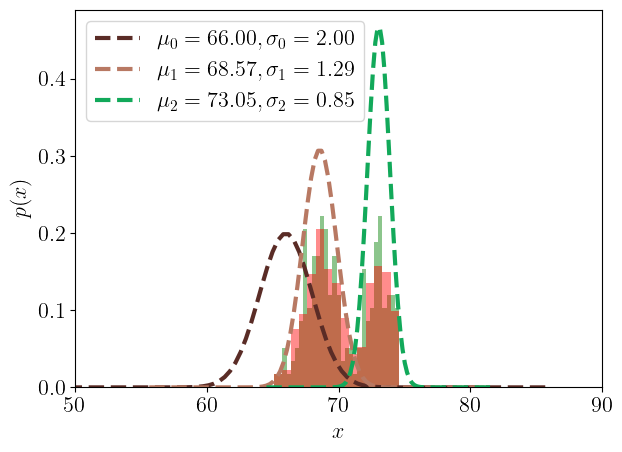

N:  185 K: 3 NLL:394.2865891263981
AIC:806.5731782527962
BIC:417.77819033925056


In [89]:
# Basic parameters of the mixture model
N = data.shape[0]  # Number of data points
K = 3  # set number of components components GMM    *** CHANGE THIS TO CHANGE NUMBER OF GAUSSIANS
tot_iterations = 100  # stopping criteria    (Probably no need to edit this)

# Step-1 (Init) - Draw parameters for each gaussian

mu = np.random.uniform(low=mincut, high=maxcut, size=K)  # mean
sigma = np.random.uniform(low=0.5, high=2.0, size=K)  # width
pi = np.ones(K) * (1.0 / K)  # mixing coefficients (amplitudes)

# Matrices of individual weights 'responsibilities' and negative log-likelihoods
r = np.zeros(
    [K, N]
)  # responsibilities, with Mixture model # along first axis, Measurements on 2nd axis
nll_list = list()  # store the neg log-likelihood


for iteration in range(tot_iterations):
    # Step-2 (E-Step)     # Here the expectation for 'responsibility' for each model is simply

    # drawn from a Gaussian pdf, with current mean, sigma, and amplitude
    for k in range(K):
        r[k, :] = pi[k] * norm.pdf(x=data, loc=mu[k], scale=sigma[k])

    # [K,N] -> [N]      # be sure to properly normalize across K
    r = r / np.sum(r, axis=0)

    # Step-3 (M-Step)
    N_k = np.sum(r, axis=1)  # [K,N] -> [K]
    for k in range(K):  # Maximum likelihood extimates
        # update means
        mu[k] = np.sum(r[k, :] * data) / N_k[k]  # Weighted mean for each Gaussian
        # update variances
        numerator = r[k] * (data - mu[k]) ** 2
        sigma[k] = np.sqrt(
            np.sum(numerator) / N_k[k]
        )  # Weighted width for each Gaussian

        if k == 0:
            sigma[k] = 2
            mu[k] = 66
            

        # See questions - you might insert code for fixing params here in order to model OUTLIERS

    # update weights
    pi = N_k / N  # New updated amplitude

    likelihood = 0.0
    for k in range(K):
        likelihood += pi[k] * norm.pdf(
            x=data, loc=mu[k], scale=sigma[k]
        )  # calculate new likelihood
    nll_list.append(-np.sum(np.log(likelihood)))
    # Check for invalid negative log-likelihood (NLL)
    # The NLL is invalid if NLL_t-1 < NLL_t
    # Note that this can happen for round-off errors.  DS - added int to avoid chronic round-off errors
    if len(nll_list) >= 2:
        if int(nll_list[-2] * 1e7) < int(nll_list[-1] * 1e7):
            raise Exception("[ERROR] invalid NLL: " + str(nll_list[-2:]))

    # print("Iteration: " + str(iteration) + "; NLL: " + str(nll_list[-1]))
    # print("Mean " + str(mu) + "\nStd " + str(sigma) + "\nWeights " + str(pi) + "\n")

    # Step-4 (Check)
    if iteration == tot_iterations - 1:
        break  # check iteration

# Make plots
plot_likelihood(nll_list)

# SAMPLE from the GMM, 1000 data points, for comparison with the measured data
data_gmm = sampler(pi, mu, sigma, N=1000)
plot_distributions(
    data,
    data_gmm,
    mu,
    sigma,
    K,
    color="green",
    color_sampled="red",
    name="plot_sampler.png",
)

# Calculate AIC and BIC assuming k gaussians with 3 parameters each
# number of free parameters for k gaussians with 3 free parameters p=3k−1,
BIC = nll_list[-1] + (3 * K) / 2 * np.log(N)
AIC = 2 * (3 * K) + 2 * nll_list[-1]
# Remember NLL is negative log-likelihood!
print("N:  " + str(N) + " K: " + str(K) + " NLL:" + str(nll_list[-1]))
print("AIC:" + str(AIC))
print("BIC:" + str(BIC))